# References:
1. https://www.kaggle.com/hely333/eda-regression

# Dataset
1. https://www.kaggle.com/fayomi/advertising
2. https://www.kaggle.com/harlfoxem/housesalesprediction
3. https://github.com/awesomedata/awesome-public-datasets
4. https://www.kdnuggets.com/datasets/index.html
5. https://www.kaggle.com/devashish0507/big-mart-sales-prediction
6. https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

---
# 0. Imports
---

In [1]:
import warnings
import pandas                  as pd
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf

from matplotlib              import pyplot as plt
from IPython.core.display    import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn                 import linear_model
from sklearn                 import metrics

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_raw = pd.read_csv( '../data/insurance.csv' )

---
# 1.0. DATA PREPARATION
---

## 1.1. Rename columns

In [5]:
df1 = df_raw.copy()

In [6]:
# new columns name
new_cols = ['age', 'gender', 'body_mass_index', 'num_children', 'is_smoker', 'region', 'insurance_cost']

# rename
df1.columns = new_cols

## 1.2. Format data columns

In [7]:
df1.dtypes

age                  int64
gender              object
body_mass_index    float64
num_children         int64
is_smoker           object
region              object
insurance_cost     float64
dtype: object

In [8]:
df1['body_mass_index'] = np.round( df1['body_mass_index'], 1 )
df1['insurance_cost'] = np.round( df1['insurance_cost'], 2 )

In [9]:
df1.head()

,age,gender,body_mass_index,num_children,is_smoker,region,insurance_cost
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


---
# 2.0. DESCRIBE DATA
---

In [10]:
df2 = df1.copy()

## 2.1. High Level

In [11]:
print( '=== High Level ===')
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Columns: {}\n'.format( df2.shape[1] ) )

print( '=== Columns types ===' )
print( df2.dtypes )

=== High Level ===
Number of Rows: 1338
Number of Columns: 7

=== Columns types ===
age                  int64
gender              object
body_mass_index    float64
num_children         int64
is_smoker           object
region              object
insurance_cost     float64
dtype: object


In [12]:
# separate the categorical from numerical features
num_features = df2.select_dtypes( include=['int64', 'float64'] )
cat_features = df2.select_dtypes( exclude=['int64', 'float64'] )

print( 'Num of Categorical: {}'.format( cat_features.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_features.shape[1] ) )

Num of Categorical: 3
Num of Numerical: 4


## 2.2. Categorical Features

In [13]:
c = pd.DataFrame( cat_features.apply( lambda x: x.unique().shape[0], axis=0 ).reset_index() )
c.columns = ['Columns Names', 'Number of Levels']
print( c )

  Columns Names  Number of Levels
0        gender                 2
1     is_smoker                 2
2        region                 4


## 2.3. Numerical Features

In [14]:
m1 = pd.DataFrame( num_features.apply( lambda x: x.min(), axis=0 ).reset_index() )
m2 = pd.DataFrame( num_features.apply( lambda x: x.max(), axis=0 ).reset_index() )

m1.columns = ['Names', 'Minimum']
m2.columns = ['Names', 'Maximum']

m = pd.merge( m1, m2, how='inner', on='Names' )
print( m )

             Names  Minimum   Maximum
0              age    18.00     64.00
1  body_mass_index    16.00     53.10
2     num_children     0.00      5.00
3   insurance_cost  1121.87  63770.43


## 2.5. Number of NA

In [15]:
df2.isnull().sum(axis = 0)

age                0
gender             0
body_mass_index    0
num_children       0
is_smoker          0
region             0
insurance_cost     0
dtype: int64

## 2.3. Automated functions

### 2.3.1. General Information

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age                1338 non-null int64
gender             1338 non-null object
body_mass_index    1338 non-null float64
num_children       1338 non-null int64
is_smoker          1338 non-null object
region             1338 non-null object
insurance_cost     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


### 2.3.2. Describe data

In [17]:
df2.describe()

,age,body_mass_index,num_children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663303,1.094918,13270.422280
std,14.049960,6.098257,1.205493,12110.011259
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


---
# 3.0 EDA - Exploration Data Analysis
---

In [18]:
df3 = df2.copy()

In [36]:
df3.head()

,age,gender,body_mass_index,num_children,is_smoker,region,insurance_cost
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


## 3.1. Univariate Analysis

## 3.1.1. Response Variable

In [85]:
print( df3['insurance_cost'].max() )
print( df3['insurance_cost'].min() )
print( df3['insurance_cost'].shape )

print( ( df3['insurance_cost'].max() - df3['insurance_cost'].min() ) / df3.shape[0] )
print( df3['insurance_cost'].mode() )

63770.43
1121.87
(1338,)
46.82254110612855
0    1639.56
dtype: float64


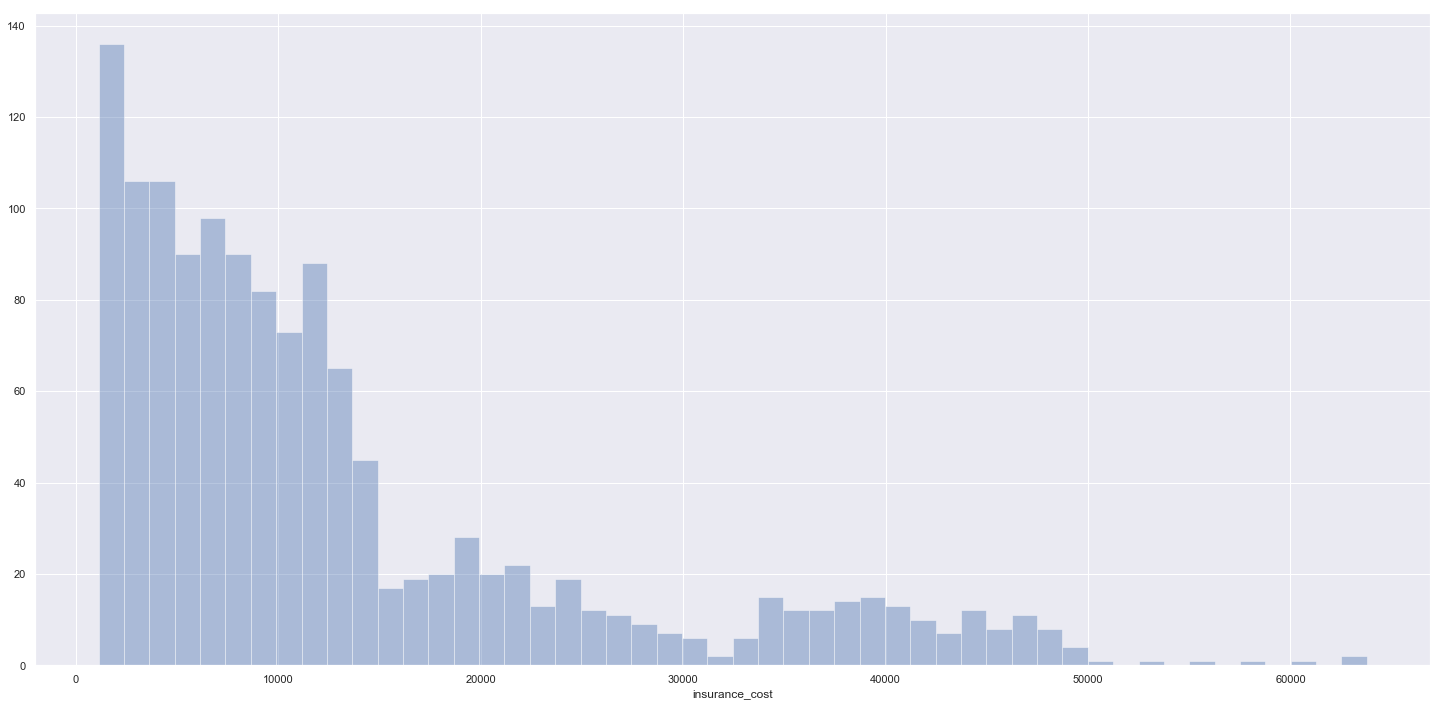

In [82]:
sns.distplot( df3['insurance_cost'], kde=False, bins=50 );

In [92]:
df3.dtypes

age                  int64
gender              object
body_mass_index    float64
num_children         int64
is_smoker           object
region              object
insurance_cost     float64
dtype: object

## 3.1.2. Numerical Predictors

### 3.1.2.1. Age

In [83]:
df3['age'].mode()

0    18
dtype: int64

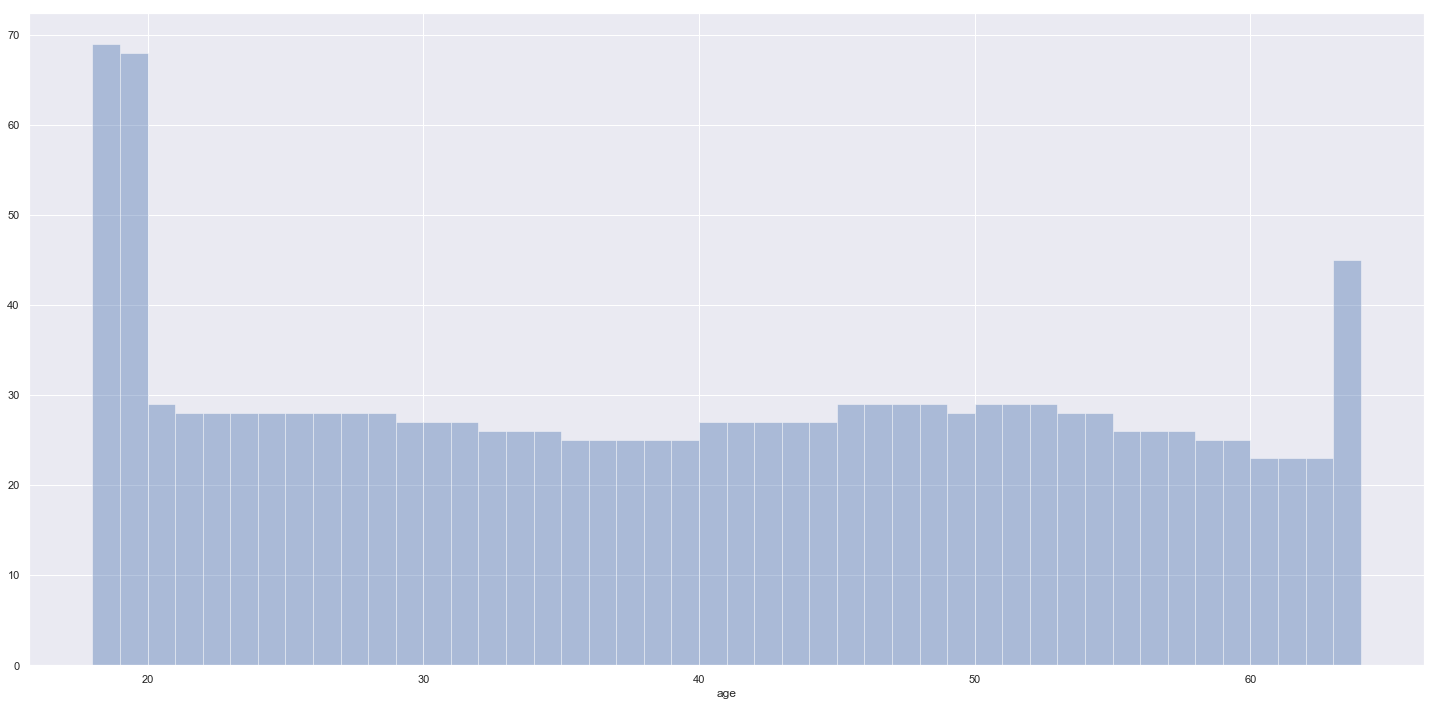

In [22]:
sns.distplot( df3['age'], kde=False, bins=46 );

### 3.1.2.2. Body Mass Index ( BMI )

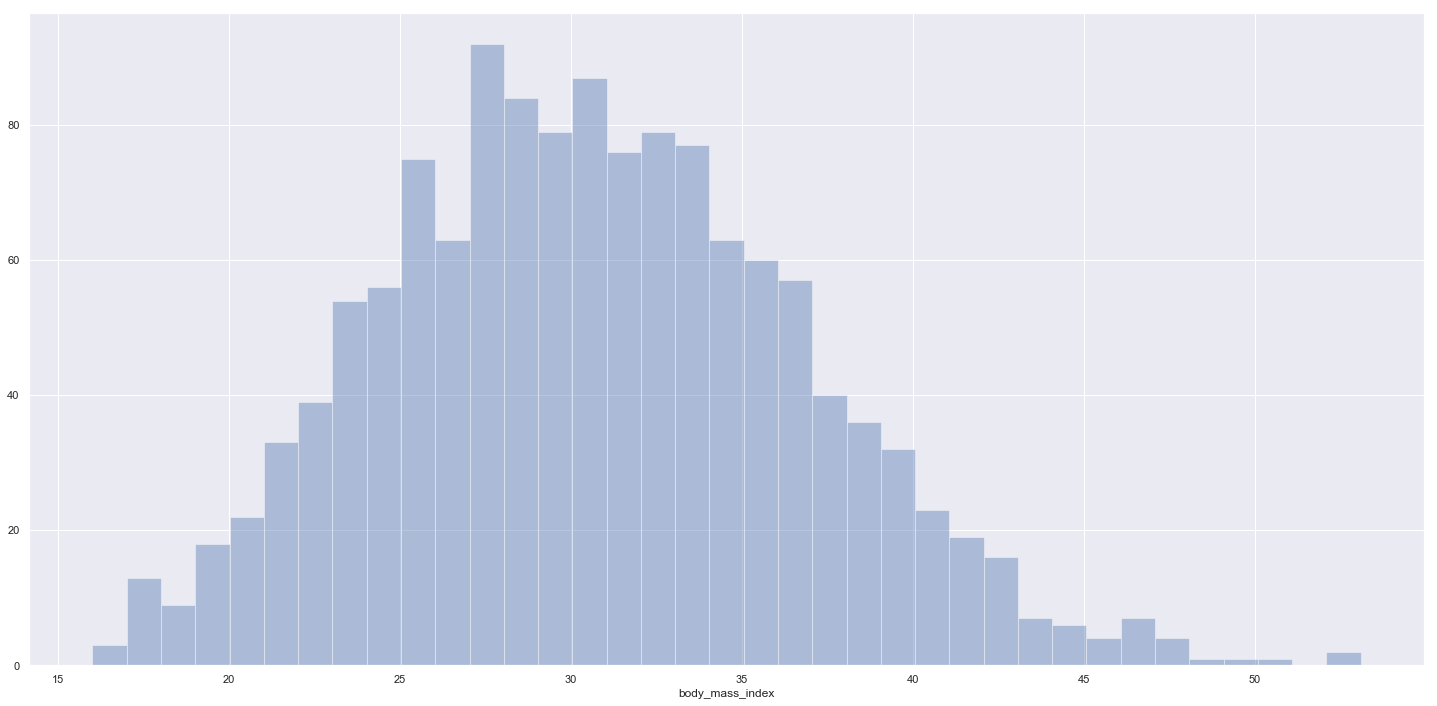

In [23]:
sns.distplot( df3['body_mass_index'], kde=False, bins=37 );

### 3.1.2.3. Number of Children

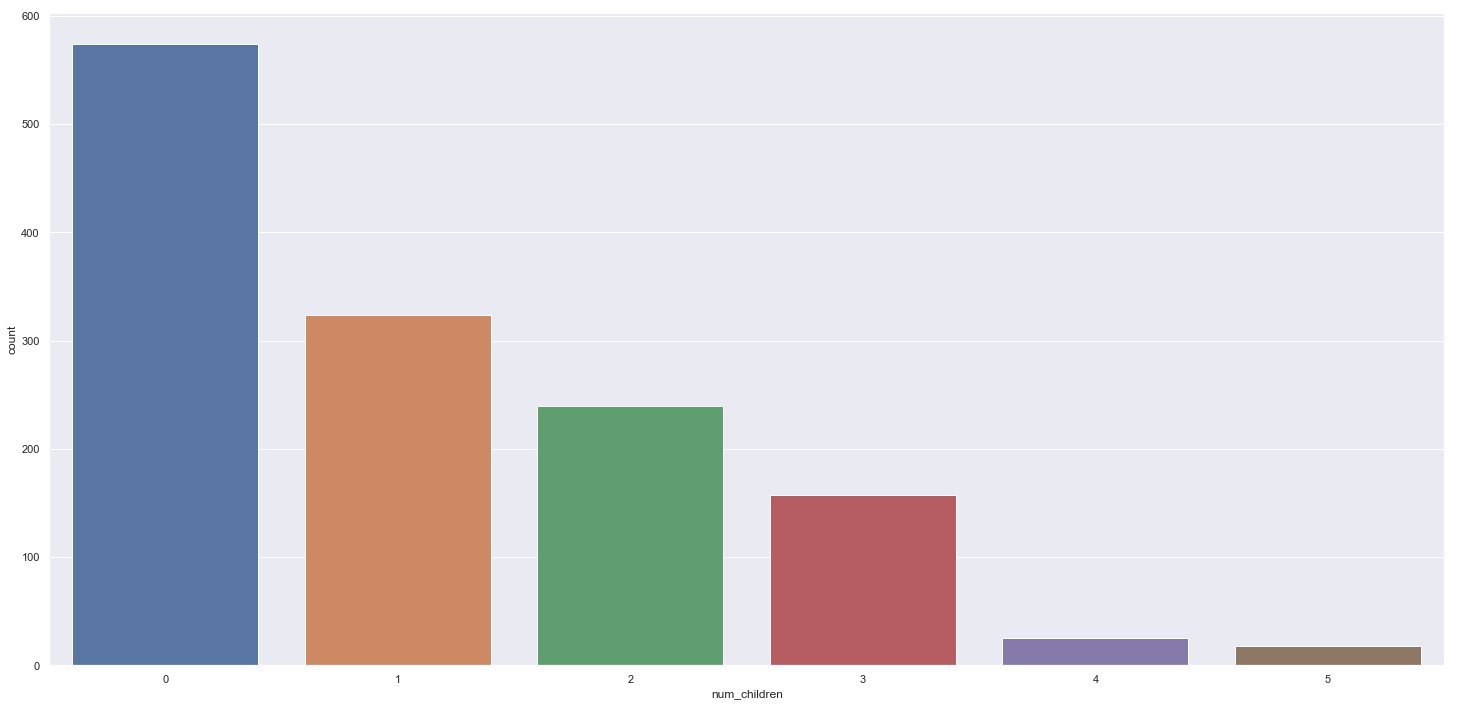

In [32]:
sns.countplot( x='num_children', data=df3 );

## 3.1.3. Categorical Predictors

### 3.1.3.1. Gender

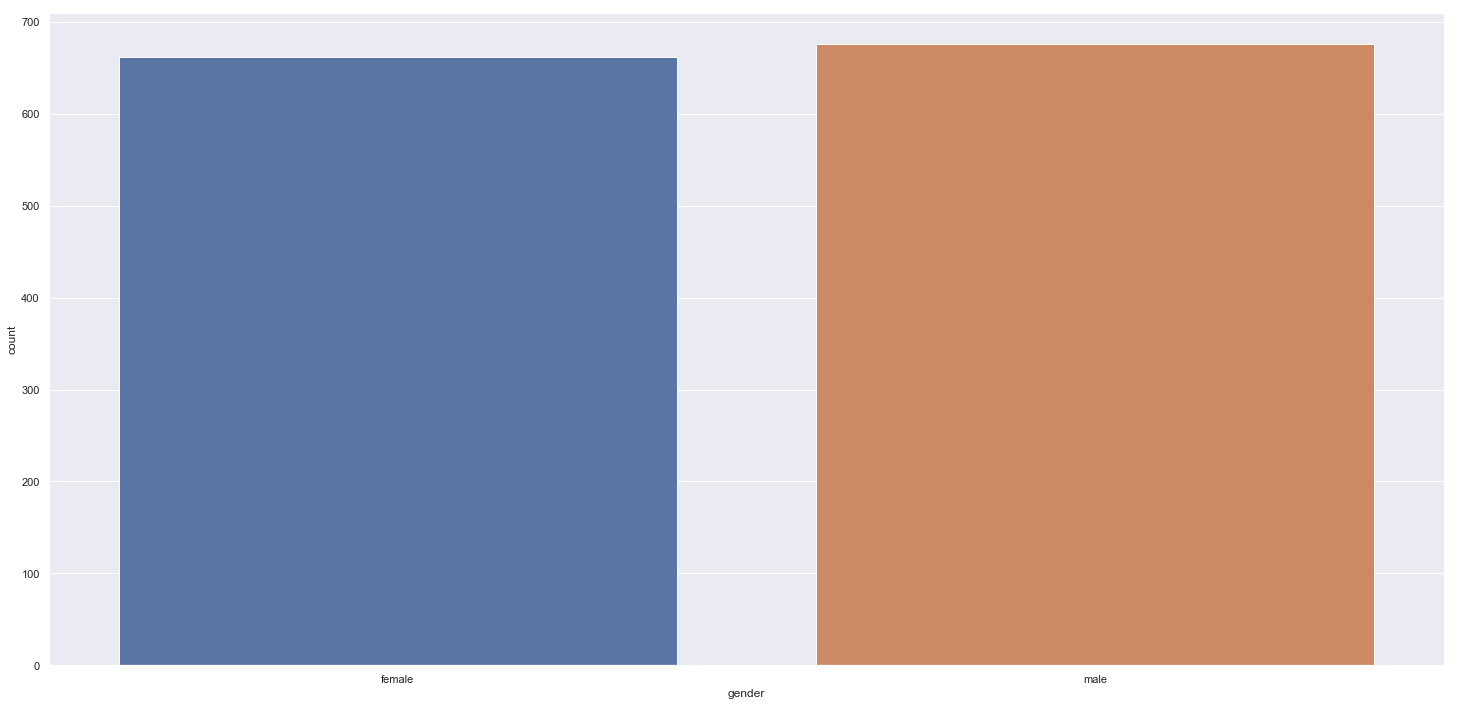

In [29]:
sns.countplot( x='gender', data=df3 );

### 3.1.3.2. Smoker

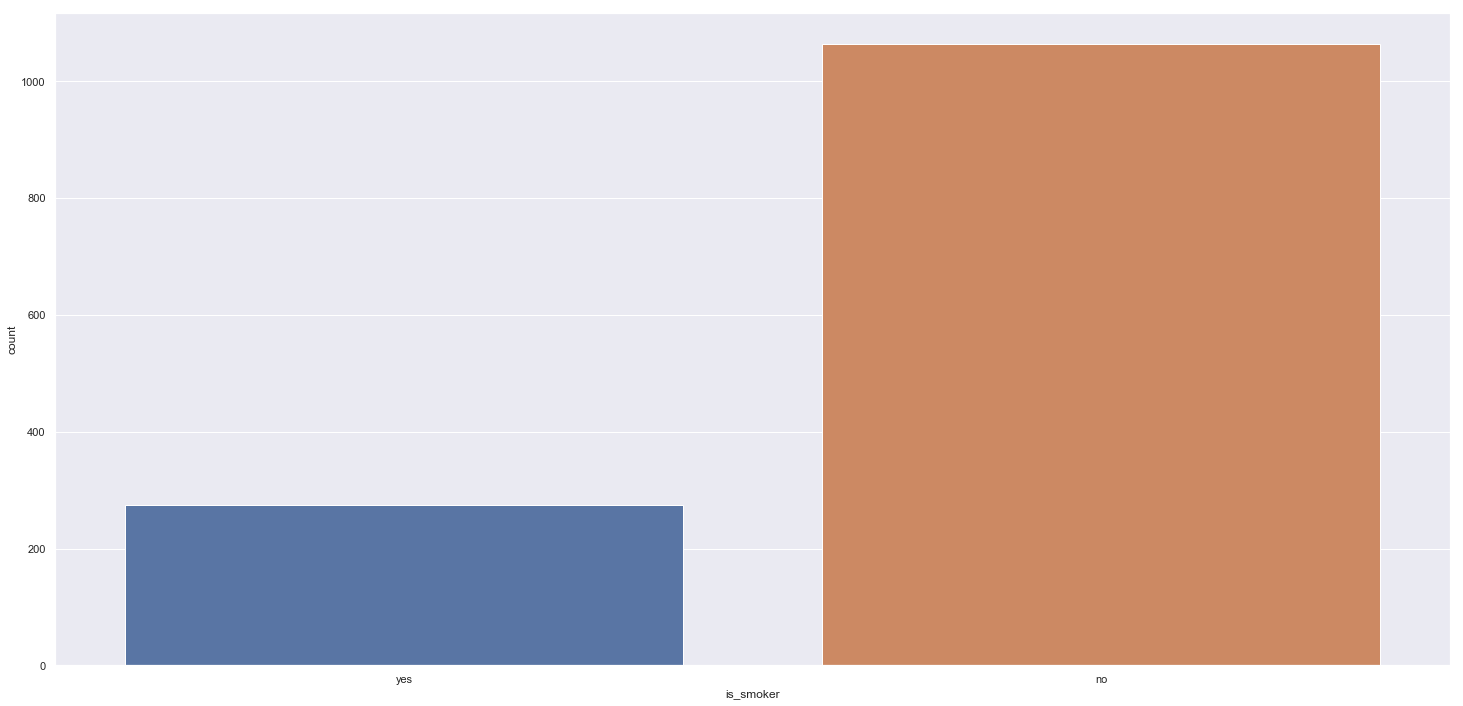

In [34]:
sns.countplot( x='is_smoker', data=df3 );

### 3.1.3.3. Region

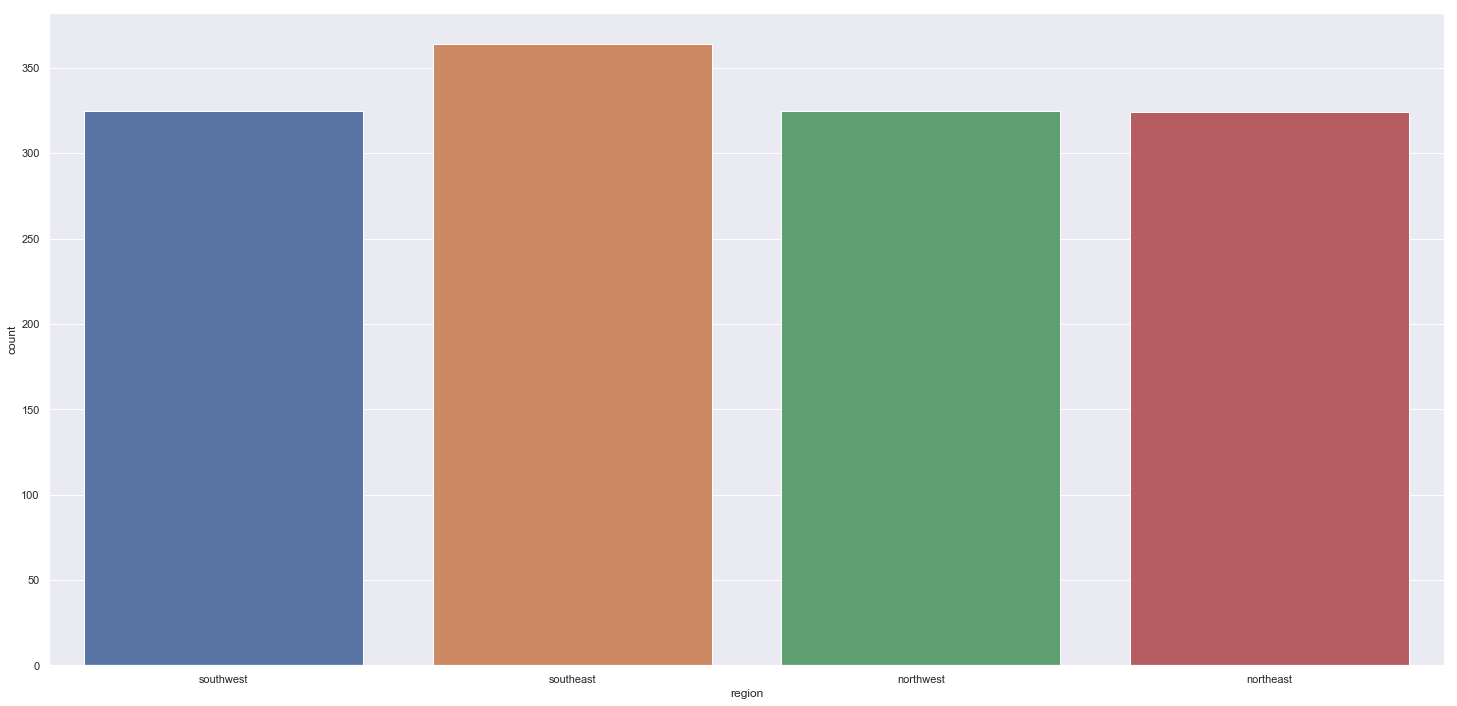

In [35]:
sns.countplot( x='region', data=df3 );

## 3.2. Bivariate Analysis

In [37]:
df3.head()

,age,gender,body_mass_index,num_children,is_smoker,region,insurance_cost
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


## 3.2.1. Numerical Predictors

### 3.2.1.1. Insurance Cost x Age

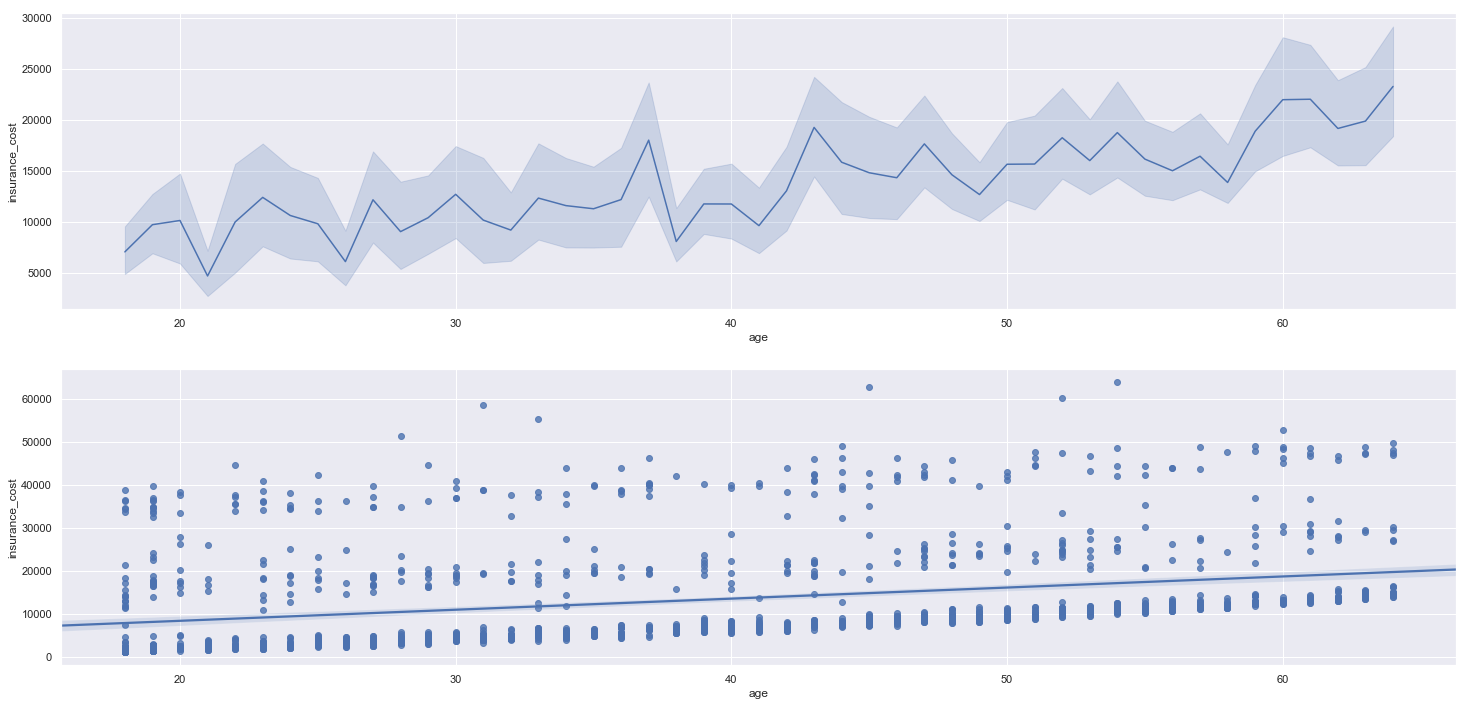

In [49]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='age', y='insurance_cost', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='age', y='insurance_cost', data=df3 );

### 3.2.1.2. Insurance Cost x Body Mass Index

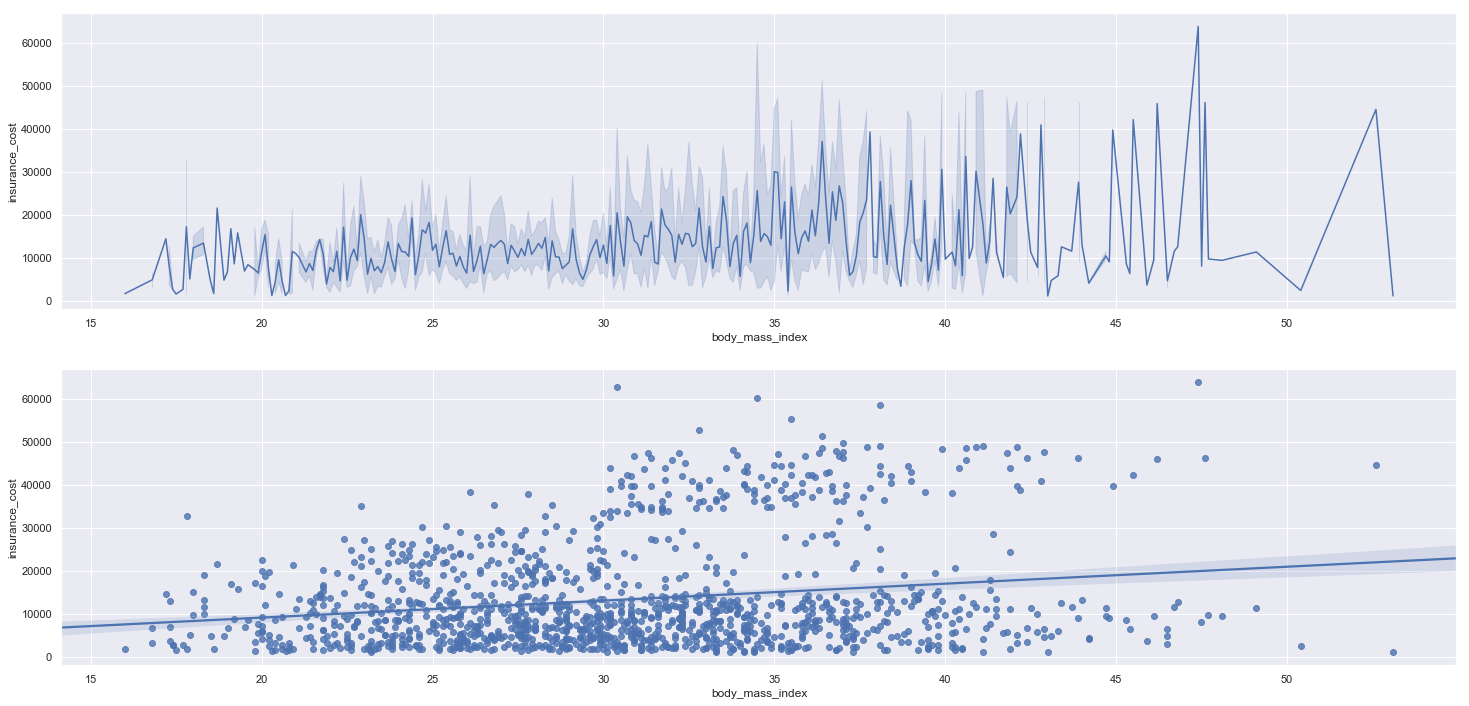

In [55]:
plt.subplot( 2, 1, 1 )
sns.lineplot( x='body_mass_index', y='insurance_cost', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='body_mass_index', y='insurance_cost', data=df3);

### 3.2.1.3. Insurance Cost x Number of Children

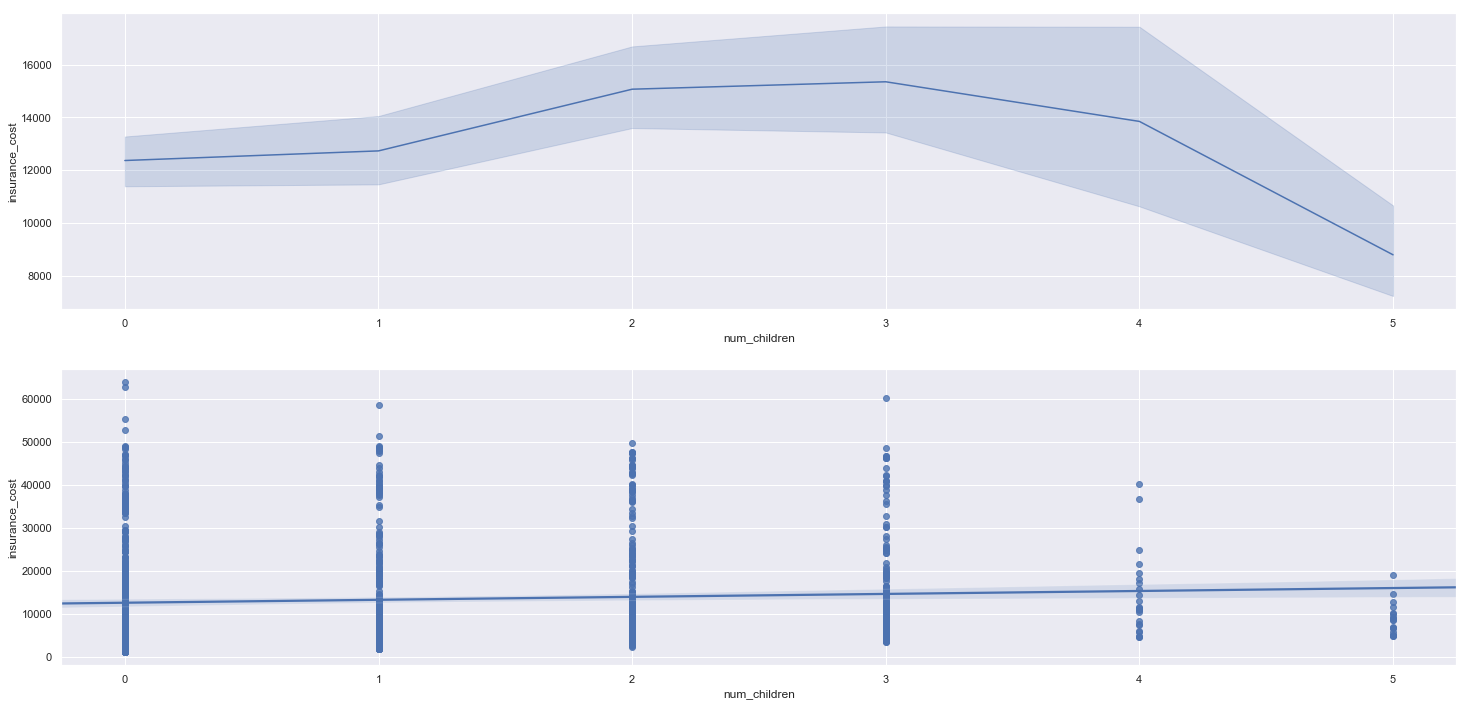

In [57]:
plt.subplot( 2, 1, 1)
sns.lineplot( x='num_children', y='insurance_cost', data=df3 );

plt.subplot( 2, 1, 2 )
sns.regplot( x='num_children', y='insurance_cost', data=df3 );

## 3.2.2. Categorical Predictors

### 3.2.2.1. Insurance Cost x Gender

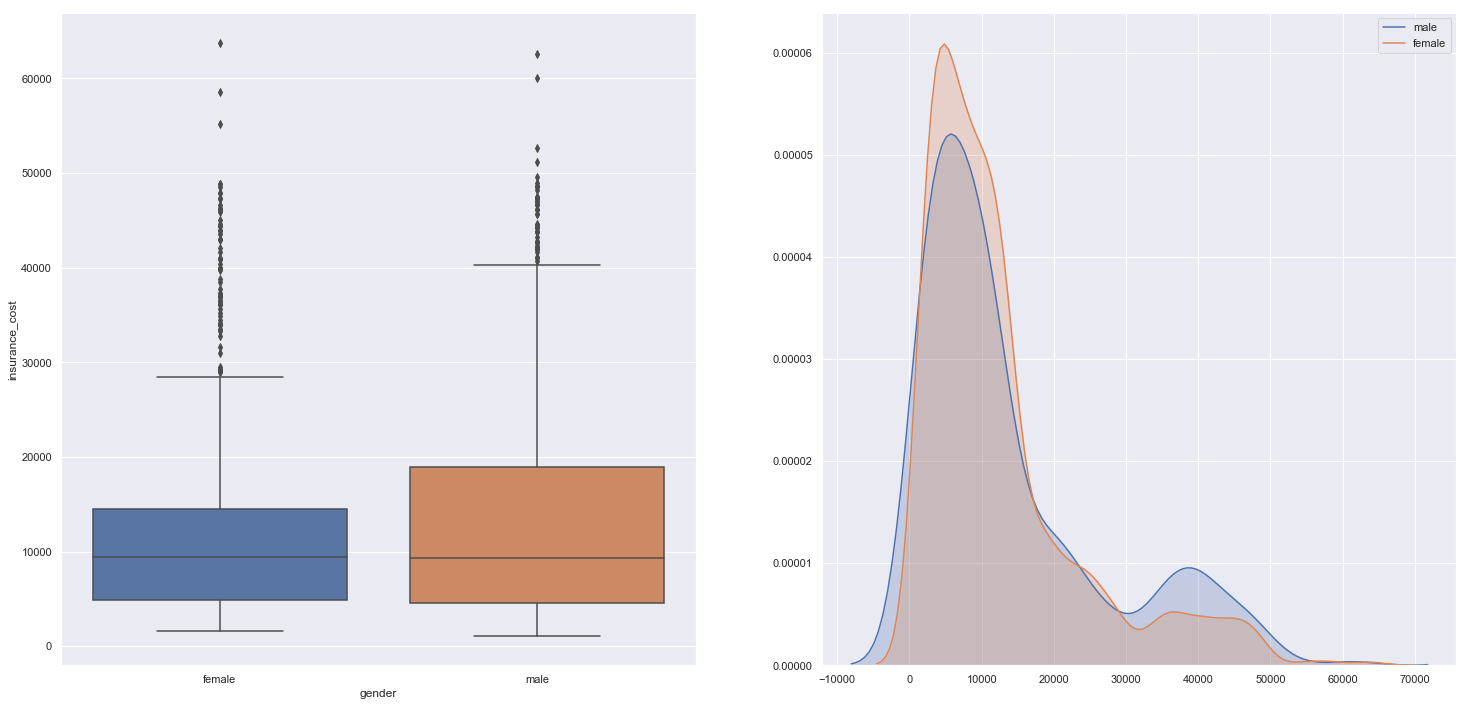

In [95]:
plt.subplot( 1, 2, 1 )
sns.boxplot( x='gender', y='insurance_cost', data=df3 );

plt.subplot( 1, 2, 2)
sns.kdeplot( df3[df3['gender'] == 'male']['insurance_cost'], label='male', shade=True );
sns.kdeplot( df3[df3['gender'] =='female']['insurance_cost'], label='female', shade=True );

### 3.2.2.2. Insurance Cost x Smoker

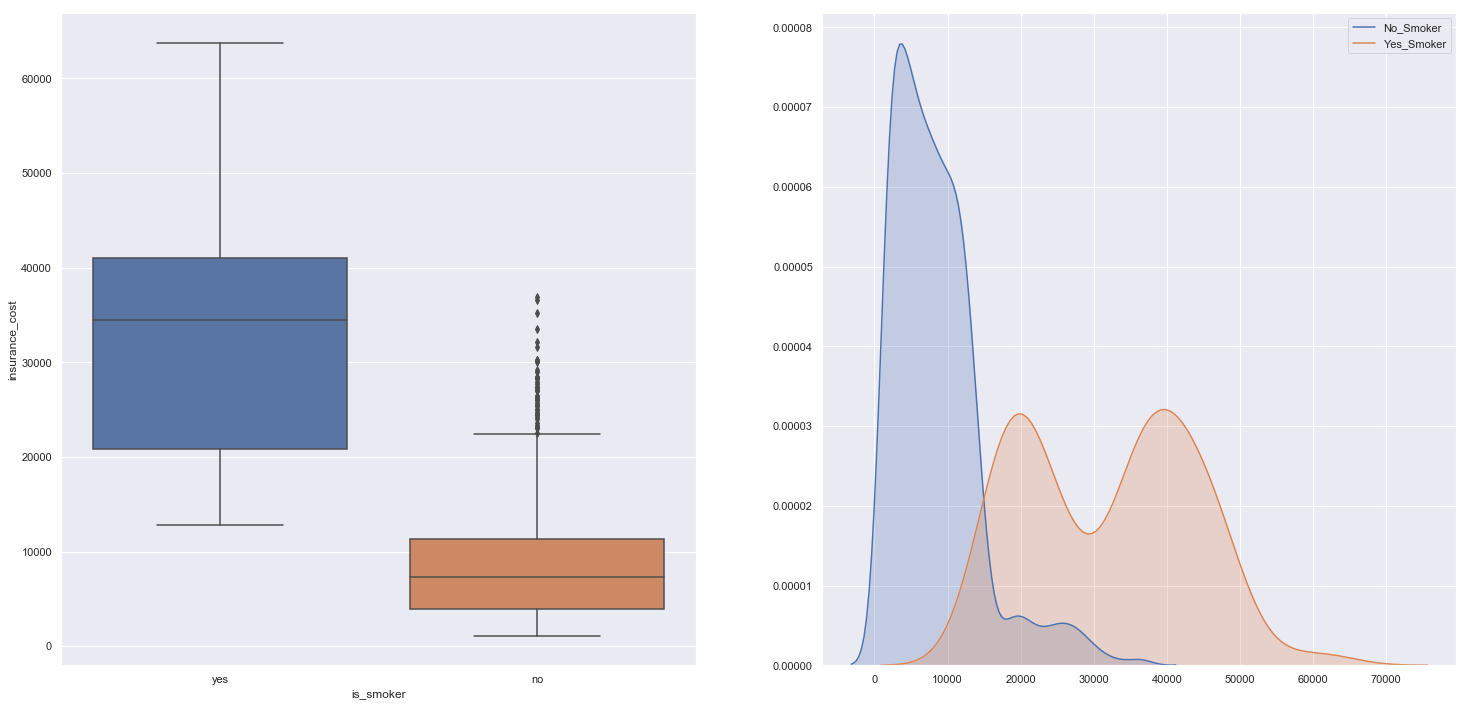

In [97]:
plt.subplot( 1, 2, 1 )
sns.boxplot( x='is_smoker', y='insurance_cost', data=df3 );

plt.subplot( 1, 2, 2)
sns.kdeplot( df3[df3['is_smoker'] == 'no']['insurance_cost'], label='No_Smoker', shade=True );
sns.kdeplot( df3[df3['is_smoker'] == 'yes']['insurance_cost'], label='Yes_Smoker', shade=True );

### 3.2.2.3. Insurance Cost x Region

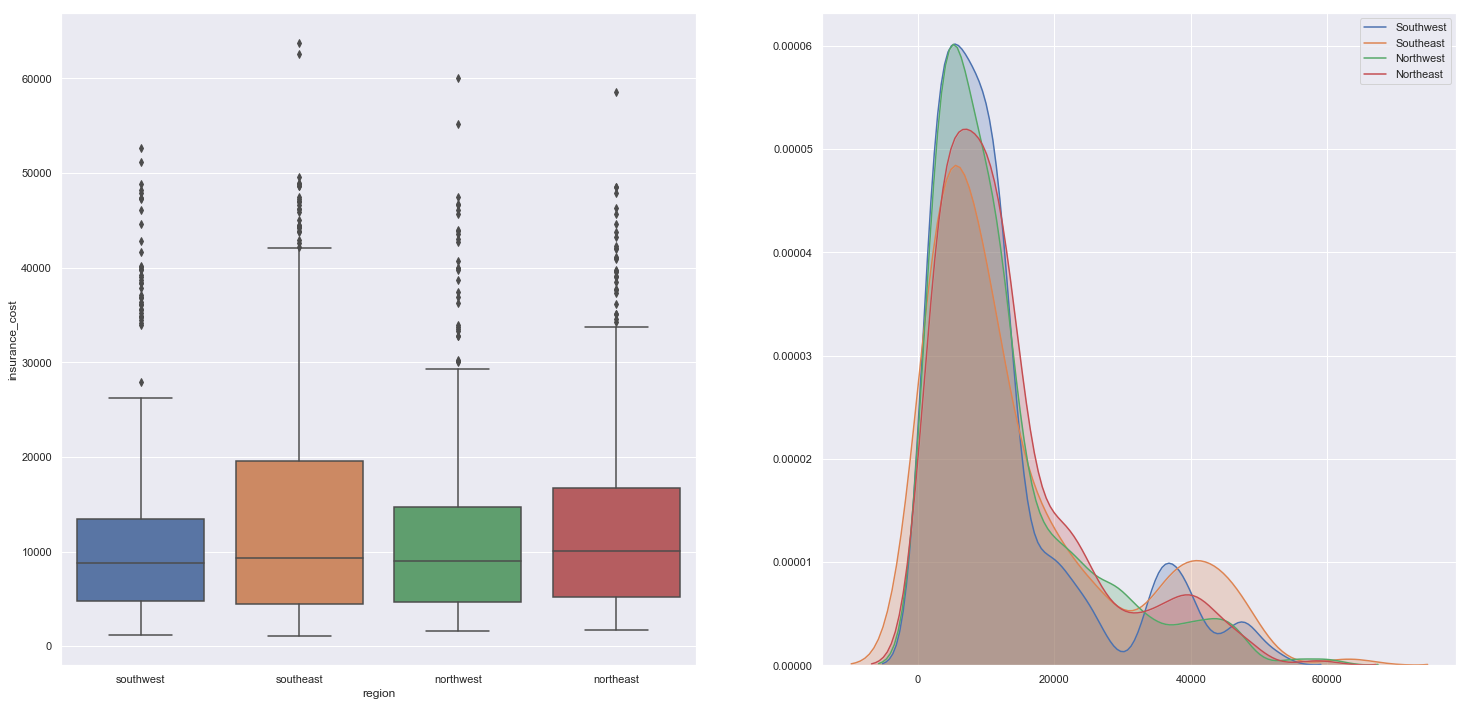

In [99]:
plt.subplot( 1, 2, 1 )
sns.boxplot( x='region', y='insurance_cost', data=df3 );

plt.subplot( 1, 2, 2)
sns.kdeplot( df3[df3['region'] == 'southwest']['insurance_cost'], label='Southwest', shade=True );
sns.kdeplot( df3[df3['region'] == 'southeast']['insurance_cost'], label='Southeast', shade=True );
sns.kdeplot( df3[df3['region'] == 'northwest']['insurance_cost'], label='Northwest', shade=True );
sns.kdeplot( df3[df3['region'] == 'northeast']['insurance_cost'], label='Northeast', shade=True );

## 3.3. Multivariate Analysis

---
# 4.0. Feature Engineering  
---

## 4.1. Create Features 

In [141]:
df4 = df3.copy()

In [142]:
# Label Encode the column: Sex
le = LabelEncoder()
le.fit( df4['gender'].drop_duplicates() )
df4['gender_label'] = le.transform( df4['gender'] )
df4 = df4.rename( columns={'gender_label': 'is_male'} )

# Label Encode the column: Smoker
le.fit( df4['is_smoker'].drop_duplicates() )
df4['is_smoker'] = le.transform( df4['is_smoker'] )

# Dummy Encode the column: Region
d = pd.get_dummies( df4['region'] )
df4 = pd.concat( [df4, d], axis=1 )

# BMI Chart
df4['bmi_cat']=df4['body_mass_index'].apply( lambda x: 'underweight' if x <=18 else 'healthy' if (x >=19)&(x <=24) else 'overweight' if (x >=25)&(x <=29) else 'obese' if (x >=30)&(x <= 39) else 'extremely_obese' ) 

# Label Encode BMI
df4['bmi_label'] = df4['bmi_cat'].apply( lambda x: -1 if x=='underweight' else 0 if x=='healthy' else 2 if x=='overweight' else 3 if x=='obese' else 4 ) 

# Dummy Encode the column: BMI_Label
d1 = pd.get_dummies( df4['bmi_cat'] )
df4 = pd.concat( [df4, d1], axis=1 )

In [143]:
df4.head()

,age,gender,body_mass_index,num_children,is_smoker,region,insurance_cost,is_male,northeast,northwest,southeast,southwest,bmi_cat,bmi_label,extremely_obese,healthy,obese,overweight,underweight
0,19,female,27.9,0,1,southwest,16884.92,0,0,0,0,1,overweight,2,0,0,0,1,0
1,18,male,33.8,1,0,southeast,1725.55,1,0,0,1,0,obese,3,0,0,1,0,0
2,28,male,33.0,3,0,southeast,4449.46,1,0,0,1,0,obese,3,0,0,1,0,0
3,33,male,22.7,0,0,northwest,21984.47,1,0,1,0,0,healthy,0,0,1,0,0,0
4,32,male,28.9,0,0,northwest,3866.86,1,0,1,0,0,overweight,2,0,0,0,1,0


## 4.2. Feature Selection

### 4.2.1 Manual Selection

In [145]:
data = df4[['age', 'body_mass_index', 'num_children', 'is_smoker', 'is_male', 'northeast', 'northwest', 'southeast', 'southwest', 'insurance_cost']]

In [146]:
data.head()

,age,body_mass_index,num_children,is_smoker,is_male,northeast,northwest,southeast,southwest,insurance_cost
0,19,27.9,0,1,0,0,0,0,1,16884.92
1,18,33.8,1,0,1,0,0,1,0,1725.55
2,28,33.0,3,0,1,0,0,1,0,4449.46
3,33,22.7,0,0,1,0,1,0,0,21984.47
4,32,28.9,0,0,1,0,1,0,0,3866.86


### 4.2.2. Univariate Selection

### 4.2.3. Recursive Feature Elimination

---
# 5.0 Data Preparation
---

## 5.1. Standardizing and Rescaling 

## 5.2. Binarization and Normalized

## 5.3. Split Data into Train and Test Sets

In [147]:
X = data.drop( 'insurance_cost', axis=1 )
y = data['insurance_cost']

In [148]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )

In [149]:
X_train.head()

,age,body_mass_index,num_children,is_smoker,is_male,northeast,northwest,southeast,southwest
912,59,26.7,3,0,0,0,1,0,0
512,51,22.4,0,0,1,1,0,0,0
153,42,23.4,0,1,0,1,0,0,0
1326,42,32.9,0,0,0,1,0,0,0
102,18,30.1,0,0,0,1,0,0,0


---
# 6.0 Modelling
---

## 6.1. Average Model

In [151]:
# Prediction
pred_avg = np.repeat( np.mean( y_train ), len( y_test ), axis=0 )

# Performance
mse = metrics.mean_squared_error( pred_avg, y_test )
rmse = np.sqrt( mse )
mae = metrics.mean_absolute_error( pred_avg, y_test )

print( 'RMSE: {}\n'.format( rmse ) )

avg_results = pd.DataFrame( {'Model': 'Avg Model', 'RMSE': rmse}, index=[0]  )
print( avg_results )

RMSE: 11459.721120920598

       Model          RMSE
0  Avg Model  11459.721121


## 6.2. Linear Regression

In [153]:
# sklearn
lm = linear_model.LinearRegression()
model = lm.fit( X_train, y_train ) 

# -------------------------------------------------
# Evaluation
# -------------------------------------------------
print( '\nPerformance')

# Prediction 
pred_lm = lm.predict( X_test )

# Performance
mse = metrics.mean_squared_error( pred_lm, y_test )
rmse = np.sqrt( mse )
mae = metrics.mean_absolute_error( pred_lm, y_test )

print( 'RMSE: {}\n'.format( rmse ) )

lm_results = pd.DataFrame( {'Model':'Linear Regression', 'RMSE': rmse }, index=[0] )
print( lm_results )


Performance
RMSE: 6177.928485958515

               Model         RMSE
0  Linear Regression  6177.928486


## 6.3. Regularized Linear Regression - LASSO

In [159]:
# sklearn
lasso = linear_model.Lasso( alpha=100 ).fit( X_train, y_train ) 

# -------------------------------------------------
# Evaluation
# -------------------------------------------------
print( '\nPerformance')

# Prediction 
pred_lasso = lasso.predict( X_test )

# Performance
mse = metrics.mean_squared_error( pred_lasso, y_test )
rmse = np.sqrt( mse )
mae = metrics.mean_absolute_error( pred_lasso, y_test )

print( 'RMSE: {}\n'.format( rmse ) )

lasso_results = pd.DataFrame( {'Model':' Lasso Linear Regression', 'RMSE': rmse }, index=[0] )
print( lasso_results )


Performance
RMSE: 6163.062445003685

                      Model         RMSE
0   Lasso Linear Regression  6163.062445


## 6.6. Random Forest

In [160]:
# sklearn
rf = RandomForestRegressor( n_estimators=1000, n_jobs=-1, random_state=0 ).fit( X_train, y_train ) 

# -------------------------------------------------
# Evaluation
# -------------------------------------------------
print( '\nPerformance')

# Prediction 
pred_rf = rf.predict( X_test )

# Performance
mse = metrics.mean_squared_error( pred_rf, y_test )
rmse = np.sqrt( mse )
print( 'RMSE: {}\n'.format( rmse ) )

rf_results = pd.DataFrame( {'Model':'Random Forest', 'RMSE': rmse }, index=[0] )
print( rf_results )


Performance
RMSE: 4822.529491473658

           Model         RMSE
0  Random Forest  4822.529491


In [167]:
a = pd.DataFrame( {'real':y_test, 'pred':pred_rf} )
a['error'] = a['pred'] - a['real']

In [176]:
a.sort_values('error', ascending=False ).head()

,real,pred,error
953,38998.55,53230.53967,14231.98967
939,9487.64,21920.76958,12433.12958
1105,10338.93,19372.54634,9033.61634
148,10959.69,19983.59105,9023.90105
28,2775.19,11454.46156,8679.27156


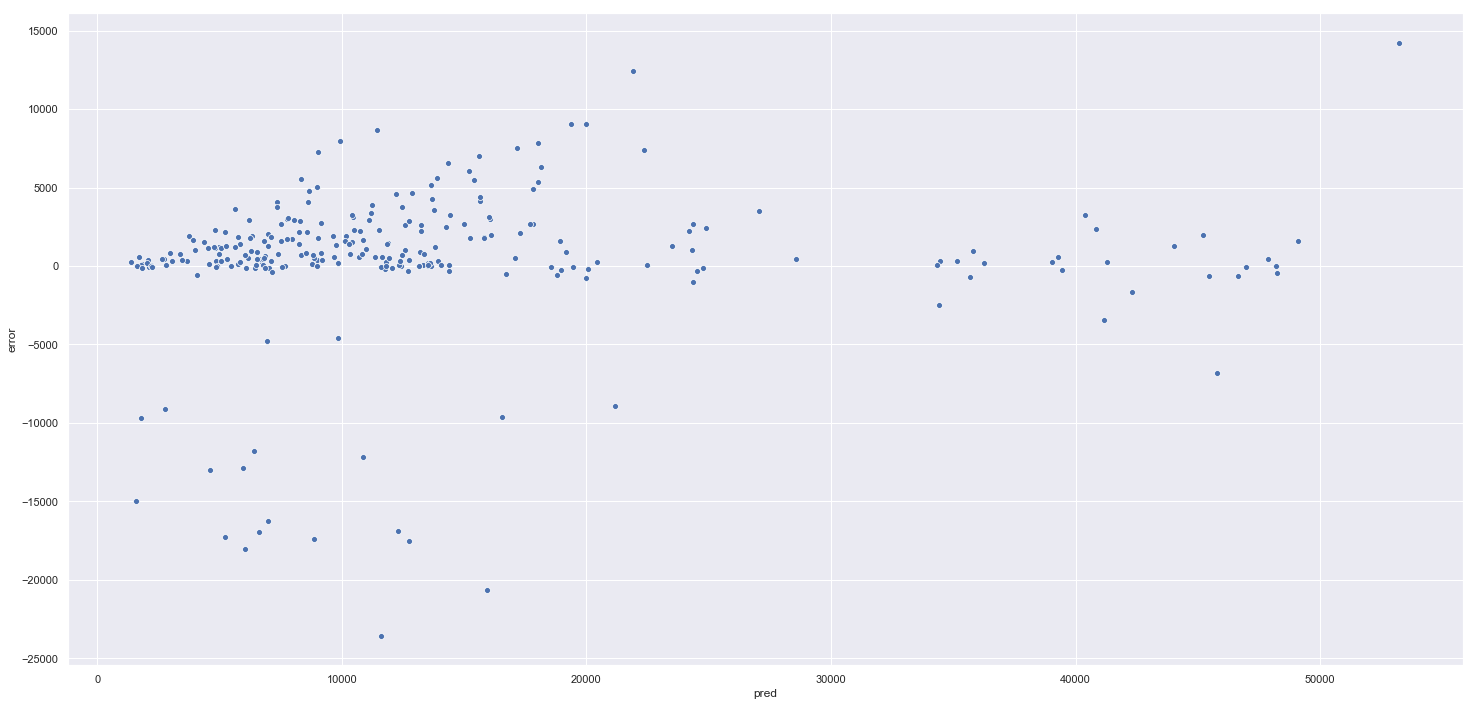

In [170]:
sns.scatterplot( x='pred', y='error', data=a )

In [168]:
a.head()

,real,pred,error
861,7151.09,7020.54025,-130.54975
8,6406.41,9163.21896,2756.80896
56,13607.37,13922.63267,315.26267
1280,8283.68,10174.26400,1890.58400
660,6435.62,8596.31308,2160.69308


---
# 7. Results
---

In [161]:
a = pd.concat( [avg_results, lm_results, lasso_results, rf_results], axis=0 )
a.sort_values( 'RMSE' )

,Model,RMSE
0,Random Forest,4822.529491
0,Lasso Linear Regression,6163.062445
0,Linear Regression,6177.928486
0,Avg Model,11459.721121


## 6.1. Training

### 6.1.1. K-Fold Cross-Validation

### 6.1.2. Leave One Out Cross-Validation